<a href="https://colab.research.google.com/github/masta-g3/robinmodel/blob/main/robinmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Predictive Features
---

In [1]:
!pip install yfinance >> /dev/null
!pip install mplcyberpunk >> /dev/null
!pip install tsmoothie >> /dev/null
!pip install pip install --upgrade ta >> /dev/null
print('Done with installs.')

Done with installs.


In [360]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplcyberpunk

from ta.momentum import RSIIndicator
from tsmoothie.smoother import LowessSmoother

plt.style.use("cyberpunk")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Loading Data & Defining Feats

*   Smoothed prices (long and short term) and returns.
*   Smooth price divergence.
*   On-balance volume.
*   RSI.



In [333]:
## Ticker data.
stock = yf.Ticker('AMD')
stock_df = stock.history(start='2020-01-01', end='2021-01-01')

In [334]:
## Lowess smoothers.
smoother = LowessSmoother(smooth_fraction=0.025, iterations=1)
stock_df['lowess_short'] = smoother.smooth(stock_df['Close']).smooth_data[0]

smoother = LowessSmoother(smooth_fraction=0.05, iterations=1)
stock_df['lowess_long'] = smoother.smooth(stock_df['Close']).smooth_data[0]

## SMAs.
stock_df['sma_5'] = stock_df['Close'].rolling(5).mean()
stock_df['sma_10'] = stock_df['Close'].rolling(10).mean()

## Divergence.
stock_df['lowess_div'] = (stock_df['lowess_long'] - stock_df['lowess_short']) / stock_df['lowess_short']
stock_df['sma_div'] = (stock_df['sma_10'] - stock_df['sma_5']) / stock_df['sma_5']

In [335]:
## Calculate returns of smoothed prices.
stock_df['ret'] = stock_df['Close'].pct_change()
stock_df['ret_smooth'] = stock_df['lowess_short'].pct_change()

hl = np.log(0.5) / np.log(0.94)
stock_df['ret_std'] = stock_df['ret'].ewm(halflife=hl).std()
stock_df['ret_std_smooth'] = stock_df['ret_smooth'].ewm(halflife=hl).std()

## Next day returns.
stock_df['ret_next'] = stock_df['ret'].shift(-1)
stock_df['ret_type'] = 0
stock_df.loc[stock_df['ret_next'] > 0.01, 'ret_type'] = 1
stock_df.loc[stock_df['ret_next'] < -0.01, 'ret_type'] = -1

## Next day returns (smooth).
stock_df['ret_next_smooth'] = stock_df['ret_smooth'].shift(-1)
stock_df['ret_type_smooth'] = 0
stock_df.loc[stock_df['ret_next_smooth'] > 0.01, 'ret_type_smooth'] = 1
stock_df.loc[stock_df['ret_next_smooth'] < -0.01, 'ret_type_smooth'] = -1

In [336]:
## On balance volume.
stock_df['obv'] = (np.sign(stock_df['ret']) * stock_df['Volume']).cumsum()
stock_df['obv_ret'] = stock_df['obv'].pct_change().clip(-.5, .5)

In [337]:
## RSI.
stock_df['rsi'] = RSIIndicator(stock_df["Close"], window=14).rsi()

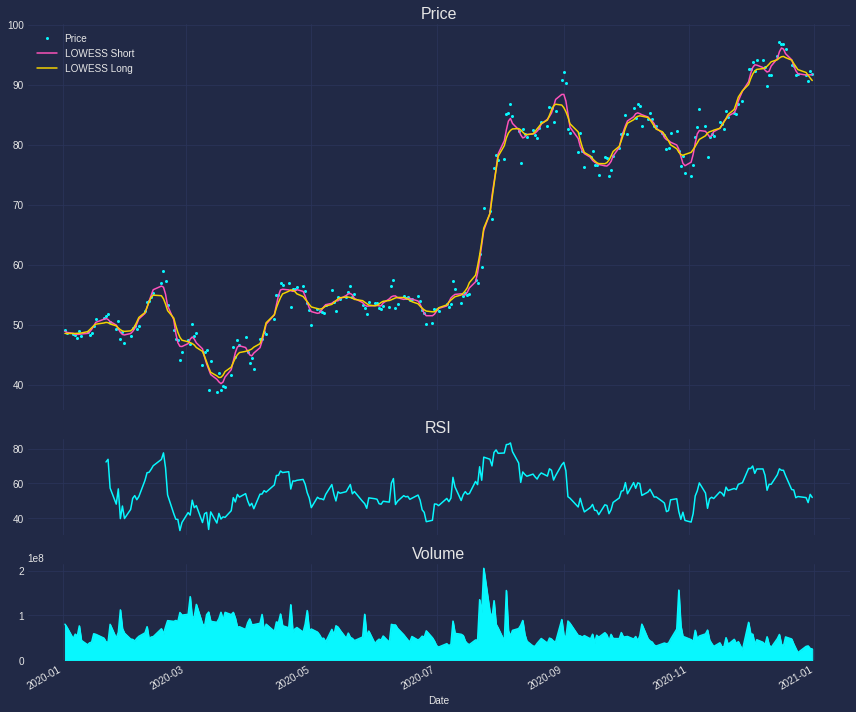

In [338]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, sharex=True,
                        gridspec_kw={'height_ratios':[4,1,1]})

## Prices and smoothed prices.
ax = axs[0]
stock_df['Close'].plot(ax=ax, ls='', marker='o', markersize=2, label='Price')
stock_df['lowess_short'].plot(ax=ax, label='LOWESS Short')
stock_df['lowess_long'].plot(ax=ax, label='LOWESS Long')

ax.legend()
ax.set_title('Price', size=16)

## Some indicator.
ax = axs[1]
stock_df['rsi'].plot(ax=ax)
ax.set_title('RSI', size=16)

## Volume.
ax = axs[2]
stock_df['Volume'].plot.area(ax=ax)
ax.set_title('Volume', size=16)

fig.tight_layout();

## Visualizing Predicitve Features

In [339]:
feats = ['sma_div', 'ret_std', 'obv_ret','rsi']

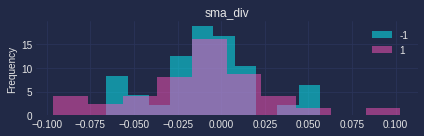

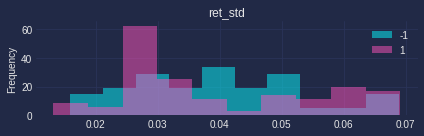

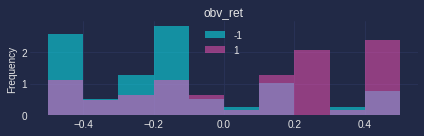

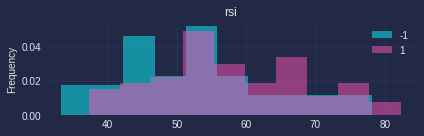

In [340]:
for feat in feats:
  fig, ax = plt.subplots(figsize=(6,2))

  plot_df = stock_df[stock_df['ret_type_smooth'] != 0]
  plot_df.groupby('ret_type_smooth')[feat].plot.hist(ax=ax, alpha=0.5,
                                                     density=True)
  ax.legend()
  ax.set_title(feat)
  fig.tight_layout();

## Feature Model

In [341]:
from sklearn.ensemble import RandomForestClassifier

In [342]:
## Create model input data.
model_df = stock_df[feats + ['Close', 'ret', 'ret_type', 'ret_type_smooth']].dropna()
model_df.loc[model_df['ret_type'] == -1, 'ret_type'] = 0
model_df.loc[model_df['ret_type_smooth'] == -1, 'ret_type_smooth'] = 0

## Divide dataset.
train_range = np.arange(0, np.ceil(model_df.shape[0] * 0.8))
test_range = np.arange(train_range[-1]+1, model_df.shape[0])

train_df = model_df.iloc[train_range].drop(columns=['ret_type'])
test_df = model_df.iloc[test_range].drop(columns=['ret_type_smooth'])

## Rename target.
train_df.rename(columns={'ret_type_smooth':'tgt'}, inplace=True)
test_df.rename(columns={'ret_type':'tgt'}, inplace=True)

In [356]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3)

clf.fit(train_df[feats], train_df['tgt'])

train_pred = clf.predict(train_df[feats])
test_pred = (clf.predict_proba(test_df[feats])[:, 1] > 0.5).astype(float)

print(sum(train_df['tgt'] == train_pred) / len(train_pred))
print(sum(test_df['tgt'] == test_pred) / len(test_pred))

0.8385416666666666
0.6666666666666666


In [357]:
list(zip(feats, clf.feature_importances_))

[('sma_div', 0.2503888674200039),
 ('ret_std', 0.3277695753964216),
 ('obv_ret', 0.23155498857920398),
 ('rsi', 0.19028656860437054)]

1.1896178832752127
0.30167688255966185


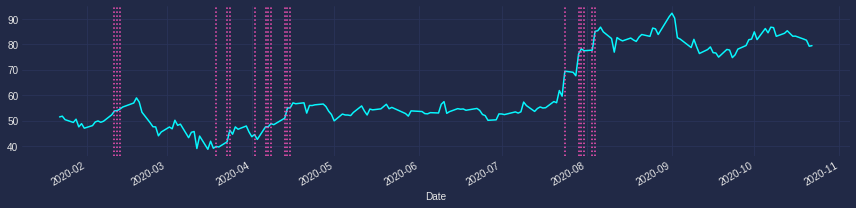

In [358]:
fig, ax = plt.subplots(figsize=(12, 3))
train_df['Close'].plot(ax=ax)
[ax.axvline(v, c=colors[1], ls=':') for v in
 train_df.loc[train_pred.astype(bool)].index]
fig.tight_layout()

print((train_df['ret'].shift(-1) * train_df['tgt']).sum())
print((train_df['ret'].shift(-1) * train_pred).sum())

0.48079691668493685
0.0


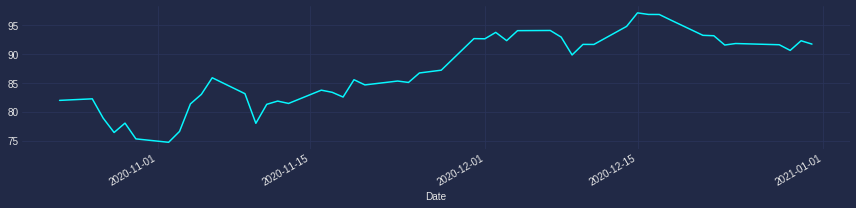

In [359]:
fig, ax = plt.subplots(figsize=(12, 3))
test_df['Close'].plot(ax=ax)
[ax.axvline(v, c=colors[1], ls=':') for v in
 test_df.loc[test_pred.astype(bool)].index]
fig.tight_layout()

print((test_df['ret'].shift(-1) * test_df['tgt']).sum())
print((test_df['ret'].shift(-1) * test_pred).sum())